In [8]:
# Code from other files in the repo
import models.recurrent_models as recurrent_models
from utilities.data_preprocessing import make_ragged_tensor
import utilities.plotlib as plotlib

# Python libraries
import pickle
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import copy

In [2]:
def f_score(cm):
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[1,0]
    FN = cm[0,1]

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f_score = 2 * (recall * precision) / (recall + precision)
    
    return f_score

In [3]:
SAVE_FOLDER = 'data_binary_classifier'
DIR = SAVE_FOLDER + '\\'

# Load files
df_jet_data = pd.read_hdf(DIR+'preprocessed_jet_data.hdf')
sample_weight = np.load(DIR+'preprocessed_sample_weights.npy', allow_pickle=True)
encoding_dict = pickle.load(open(DIR+'encoding_dict.pickle', 'rb'))
event_labels = pd.read_hdf(DIR+'preprocessed_event_labels.hdf')
event_labels = event_labels.values

test_fraction = 0.2
data_train, data_test, labels_train, labels_test_rnn, sw_train, sw_test  = \
    train_test_split(df_jet_data, event_labels, 
                      sample_weight, test_size=test_fraction)

# Take a sample of the data to speed up training
sample_num = -1
data_train = data_train[:sample_num]
data_test = data_test[:sample_num]
labels_train = labels_train[:sample_num]
labels_test_rnn = labels_test_rnn[:sample_num]
sw_train = sw_train[:sample_num]
sw_test = sw_test[:sample_num]


In [4]:
data_train_rt = make_ragged_tensor(data_train)
data_test_rt = make_ragged_tensor(data_test)
print(f"Shape: {data_train_rt.shape}")
print(f"Number of partitioned dimensions: {data_train_rt.ragged_rank}")
print(f"Flat values shape: {data_train_rt.flat_values.shape}")

Shape: (624291, None, 6)
Number of partitioned dimensions: 1
Flat values shape: (4114819, 6)


In [5]:
model = recurrent_models.base()

print("Fitting RNN model on jet training data...")
START = time.time()
history = model.fit(data_train_rt, labels_train, batch_size = 64,
                    validation_data=(data_test_rt, labels_test_rnn), 
                    sample_weight=sw_train, epochs=32, verbose=2)
print(f"    Elapsed training time: {time.time()-START:0.2f}s")

test_loss, test_acc = model.evaluate(data_test_rt, labels_test_rnn, verbose=2)
print(f"    Test accuracy: {test_acc:0.5f}")

Fitting RNN model on jet training data...
Epoch 1/32
9755/9755 - 82s - loss: 1.7516e-06 - accuracy: 0.5850 - val_loss: 0.6726 - val_accuracy: 0.6143
Epoch 2/32
9755/9755 - 86s - loss: 1.7354e-06 - accuracy: 0.5845 - val_loss: 0.6720 - val_accuracy: 0.6061
Epoch 3/32
9755/9755 - 93s - loss: 1.7240e-06 - accuracy: 0.5860 - val_loss: 0.6839 - val_accuracy: 0.5791
Epoch 4/32
9755/9755 - 97s - loss: 1.7190e-06 - accuracy: 0.5862 - val_loss: 0.6988 - val_accuracy: 0.5503
Epoch 5/32
9755/9755 - 98s - loss: 1.7175e-06 - accuracy: 0.5868 - val_loss: 0.6774 - val_accuracy: 0.5911
Epoch 6/32
9755/9755 - 103s - loss: 1.7165e-06 - accuracy: 0.5871 - val_loss: 0.6686 - val_accuracy: 0.6067
Epoch 7/32
9755/9755 - 104s - loss: 1.7155e-06 - accuracy: 0.5878 - val_loss: 0.6841 - val_accuracy: 0.5790
Epoch 8/32
9755/9755 - 112s - loss: 1.7142e-06 - accuracy: 0.5888 - val_loss: 0.6798 - val_accuracy: 0.5856
Epoch 9/32
9755/9755 - 106s - loss: 1.7131e-06 - accuracy: 0.5874 - val_loss: 0.6888 - val_accuracy

In [10]:
systematic_error_data = copy.deepcopy(data_test)
systematic_error = []
fscore_list_shifted = []
for i in range(31):
    I = 1 + i / 100
    systematic_error_data.CleanJet_mass = data_test.CleanJet_mass * I
    systematic_error_data_rt = make_ragged_tensor(systematic_error_data)
    labels_pred = model.predict(systematic_error_data_rt)

    cutoff_threshold = 0.5 
    labels_pred_binary = np.where(labels_pred > cutoff_threshold, 1, 0)

    cm = confusion_matrix(labels_test_rnn, labels_pred_binary)
    fscore_list_shifted += [f_score(cm)]
    systematic_error += [i]
    
    

Text(0.5, 1.0, 'Network response to systematic error')

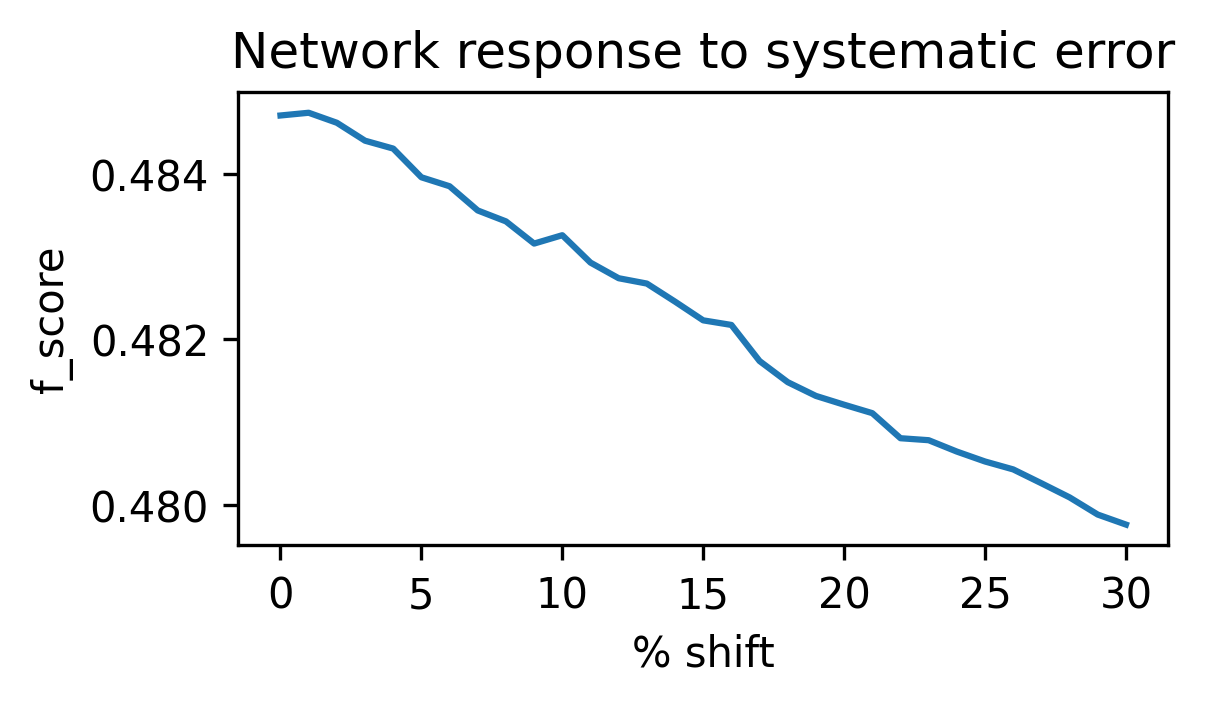

In [11]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
ax.plot(systematic_error, fscore_list_shifted)
ax.set_xlabel('% shift')
ax.set_ylabel('f_score')
ax.set_title('Network response to systematic error')

In [17]:
smeared_error_data = copy.deepcopy(data_test)
gaussian_spread = []
fscore_list_smeared = []
for i in range(31):
    print(i)
    start = time.time()
    std = i/100
    smeared_error_data.CleanJet_mass = smeared_error_data.CleanJet_mass.apply(lambda x: x * np.random.normal(1, std, len(x)))
    smeared_error_data_rt = make_ragged_tensor(smeared_error_data)
    
    labels_pred = model.predict(systematic_error_data_rt)

    cutoff_threshold = 0.5 
    labels_pred_binary = np.where(labels_pred > cutoff_threshold, 1, 0)

    cm = confusion_matrix(labels_test_rnn, labels_pred_binary)
    fscore_list_smeared += [f_score(cm)]
    gaussian_spread += [i]
    end = time.time()
    print(end-start)
    

0
18.44087553024292
1
18.041024684906006
2
18.161412000656128
3
18.067476511001587
4
18.201749563217163
5
18.01776146888733
6
18.645397424697876
7
18.2186119556427
8
18.5001163482666
9
18.225450038909912
10
18.067453622817993
11
18.246871948242188
12
18.219467163085938
13
17.85123109817505
14
18.402450561523438
15
18.446637392044067
16
18.080334186553955
17
17.85417079925537
18
18.050069332122803
19
18.42394208908081
20
17.90615153312683
21
18.19692873954773
22
17.563201189041138
23
18.197932243347168
24
17.61888027191162
25
17.820491313934326
26
17.81740093231201
27
18.543518543243408
28
17.629201650619507
29
18.182474613189697
30
18.02150845527649


Text(0.5, 1.0, 'Network response to measurment error')

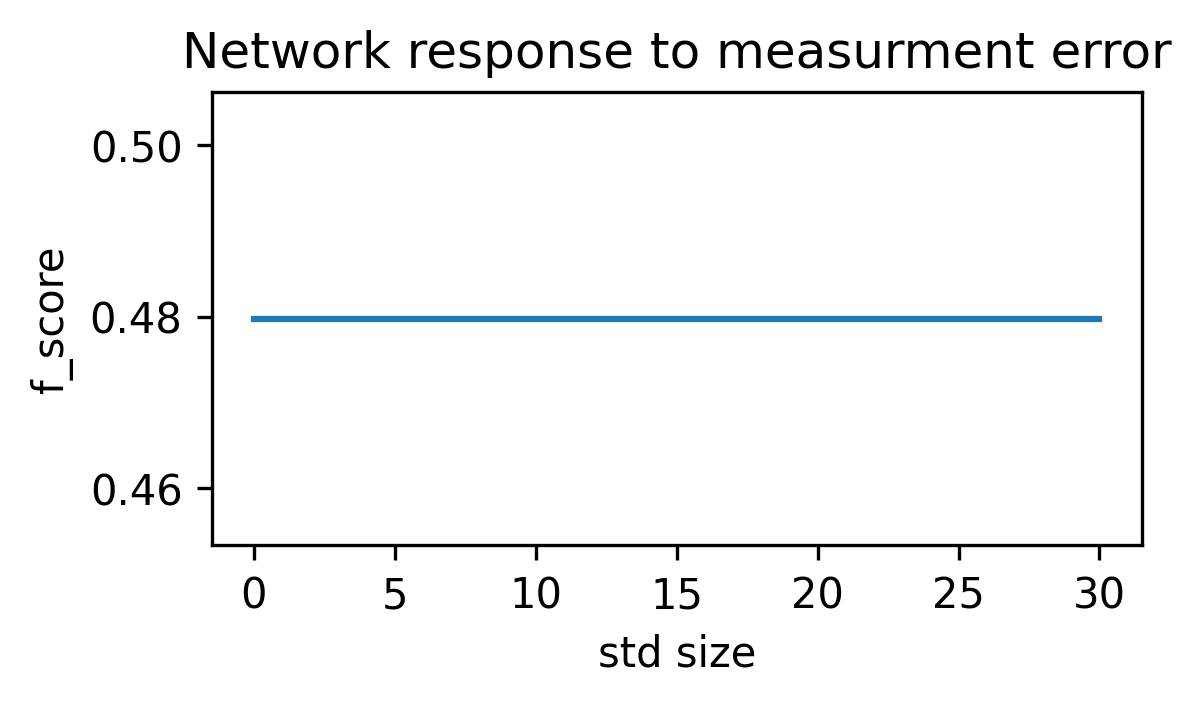

In [18]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
ax.plot(gaussian_spread, fscore_list_smeared)
ax.set_xlabel('std size')
ax.set_ylabel('f_score')
ax.set_title('Network response to measurment error')

Fitting sequential model on event training data...
Epoch 1/16
9755/9755 - 28s - loss: 1.7249e-06 - accuracy: 0.5318 - val_loss: 0.6498 - val_accuracy: 0.6181
Epoch 2/16
9755/9755 - 27s - loss: 1.6214e-06 - accuracy: 0.5971 - val_loss: 0.6164 - val_accuracy: 0.6591
Epoch 3/16
9755/9755 - 26s - loss: 1.5955e-06 - accuracy: 0.6226 - val_loss: 0.6106 - val_accuracy: 0.6599
Epoch 4/16
9755/9755 - 27s - loss: 1.5851e-06 - accuracy: 0.6325 - val_loss: 0.6088 - val_accuracy: 0.6531
Epoch 5/16
9755/9755 - 30s - loss: 1.5656e-06 - accuracy: 0.6351 - val_loss: 0.6185 - val_accuracy: 0.6507
Epoch 6/16
9755/9755 - 28s - loss: 1.5587e-06 - accuracy: 0.6355 - val_loss: 0.6091 - val_accuracy: 0.6501
Epoch 7/16
9755/9755 - 30s - loss: 1.5524e-06 - accuracy: 0.6359 - val_loss: 0.6132 - val_accuracy: 0.6358
Epoch 8/16
9755/9755 - 30s - loss: 1.5578e-06 - accuracy: 0.6324 - val_loss: 0.6433 - val_accuracy: 0.6189
Epoch 9/16
9755/9755 - 30s - loss: 1.5514e-06 - accuracy: 0.6325 - val_loss: 0.6375 - val_acc

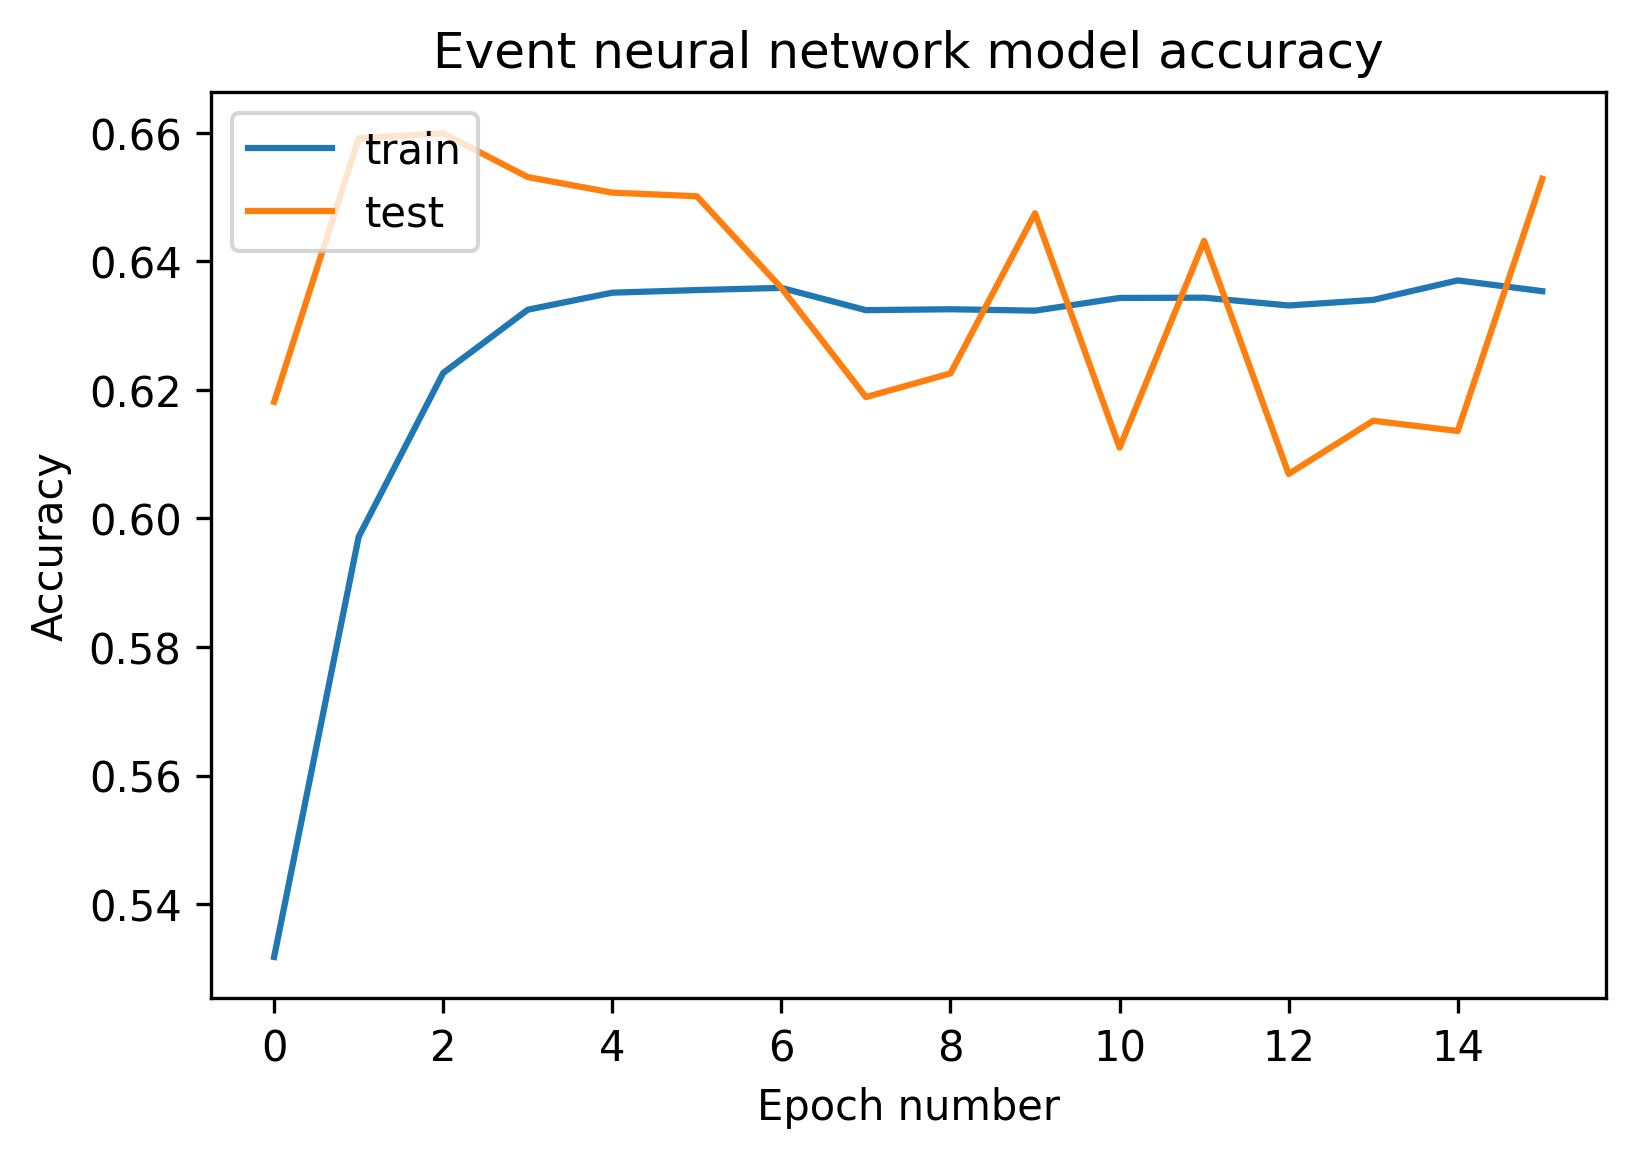

In [70]:
# Plot training history
fig1 = plotlib.training_history_plot(history, 'Event neural network model accuracy')

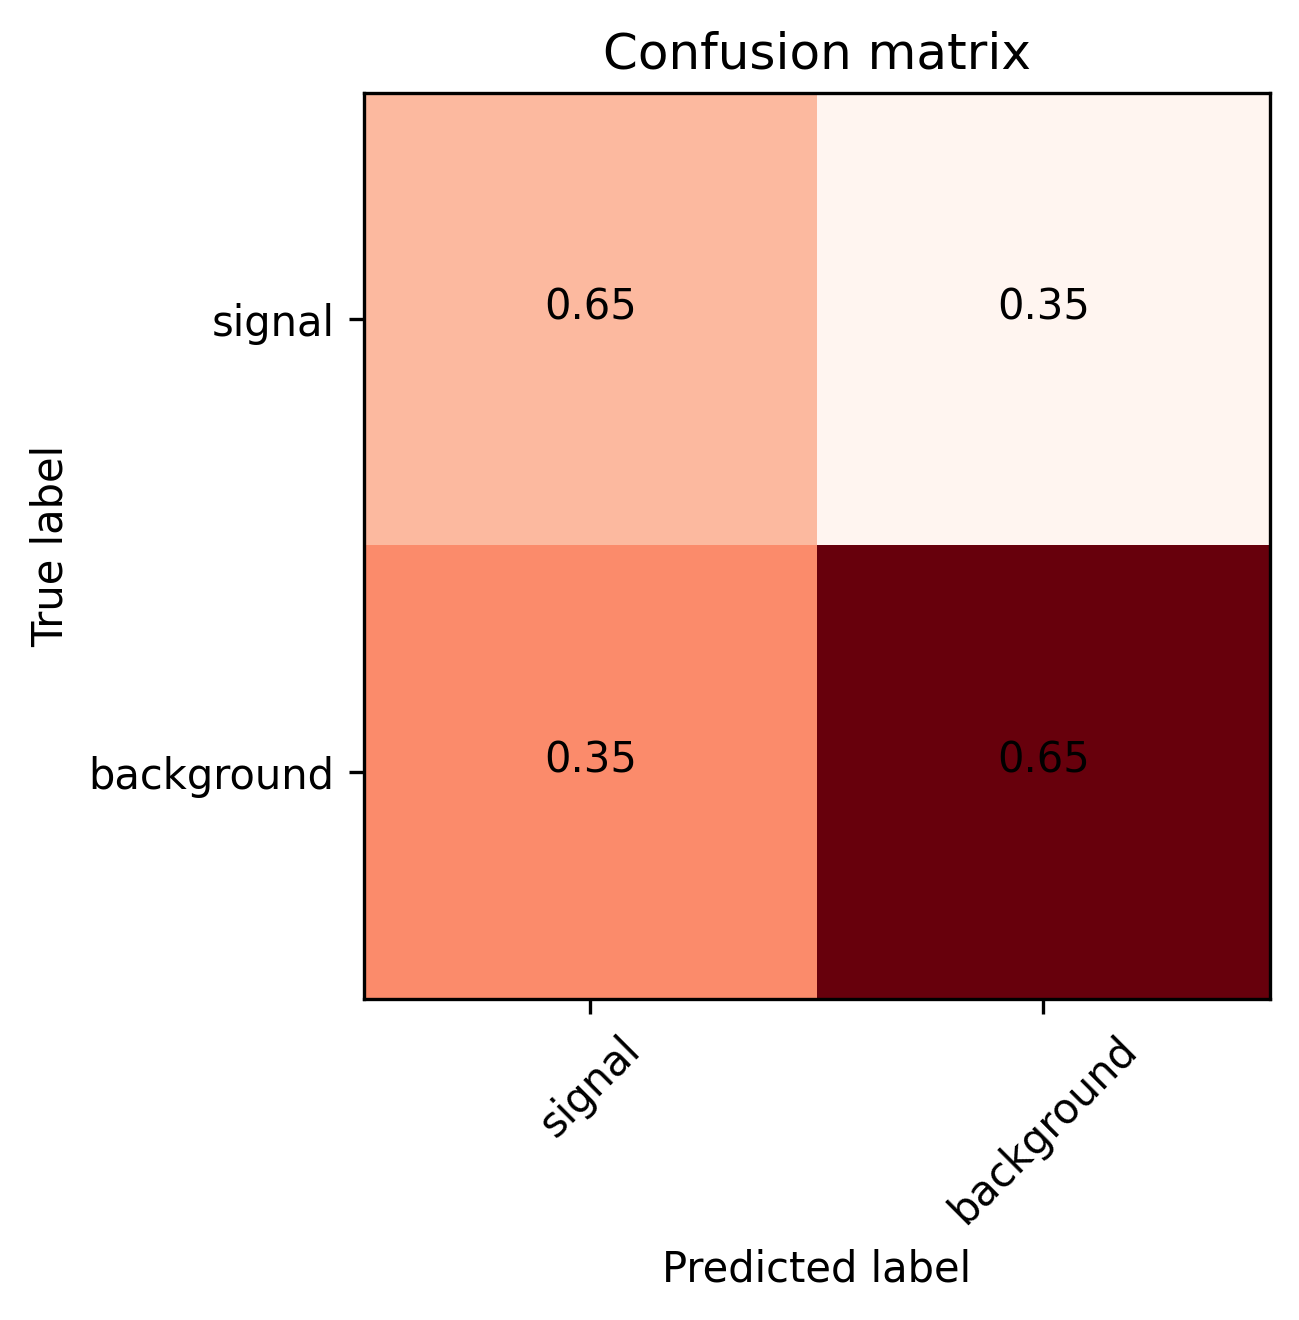

In [71]:
# Get model predictions
labels_pred = model.predict(normalised_data_test)

# Convert predictions into binary values
cutoff_threshold = 0.5 
labels_pred_binary = np.where(labels_pred > cutoff_threshold, 1, 0)

# Make confsuion matrix
cm = confusion_matrix(labels_test, labels_pred_binary)
class_names = ['signal', 'background']
title = 'Confusion matrix'

# Plot confusion matrix
fig2 = plotlib.confusion_matrix(cm, class_names, title)

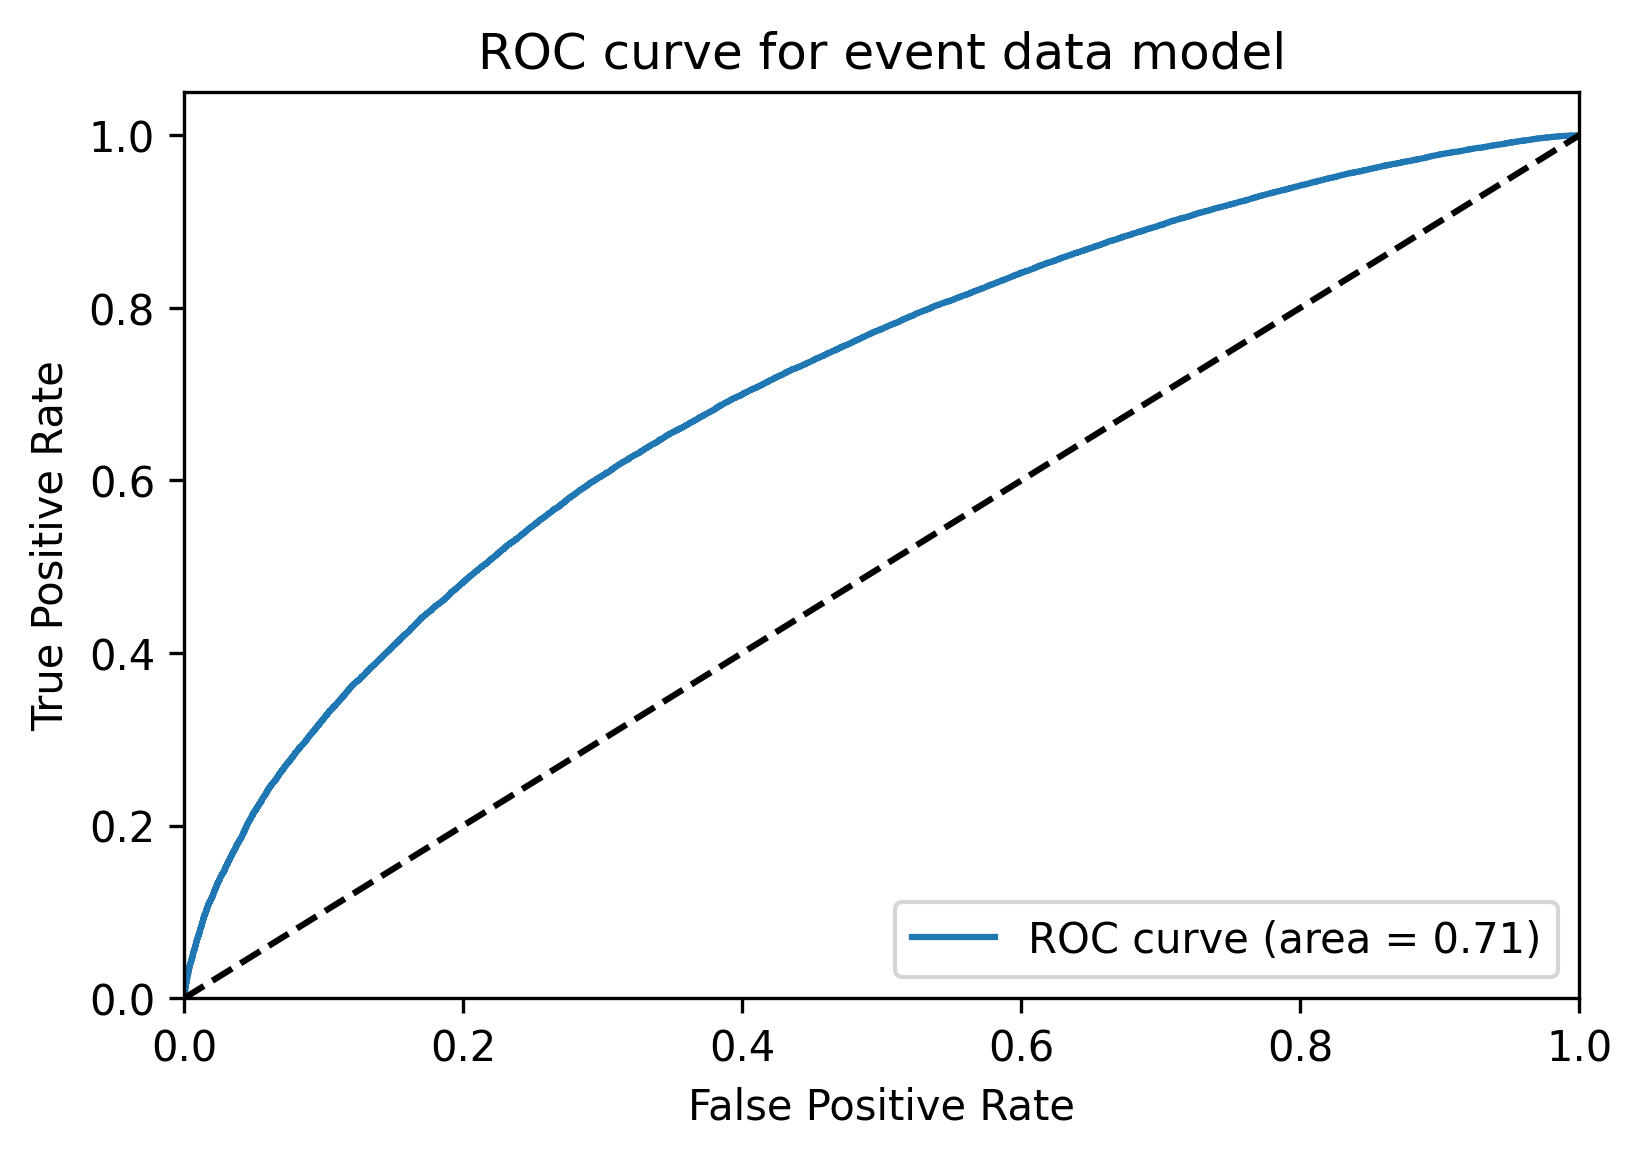

In [72]:
# Plot ROC curve
title_roc = 'ROC curve for event data model'
fig3 = plotlib.plot_roc(labels_pred, labels_test, title_roc)

(0.0, 6000.0)

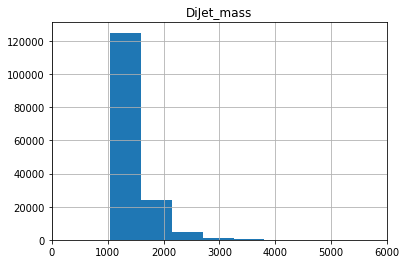

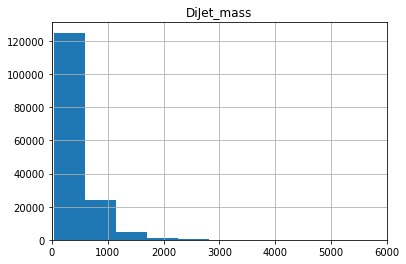

In [88]:
systematic_error_data = copy.deepcopy(data_test)
systematic_jet_data = data_test.DiJet_mass.values

systematic_error_data.loc[:,'DiJet_mass'] = systematic_jet_data + 1000

ax1 = systematic_error_data.hist('DiJet_mass')
ax2 = data_test.hist('DiJet_mass')
ax1[0][0].set_xlim(0,6000)
ax2[0][0].set_xlim(0,6000)

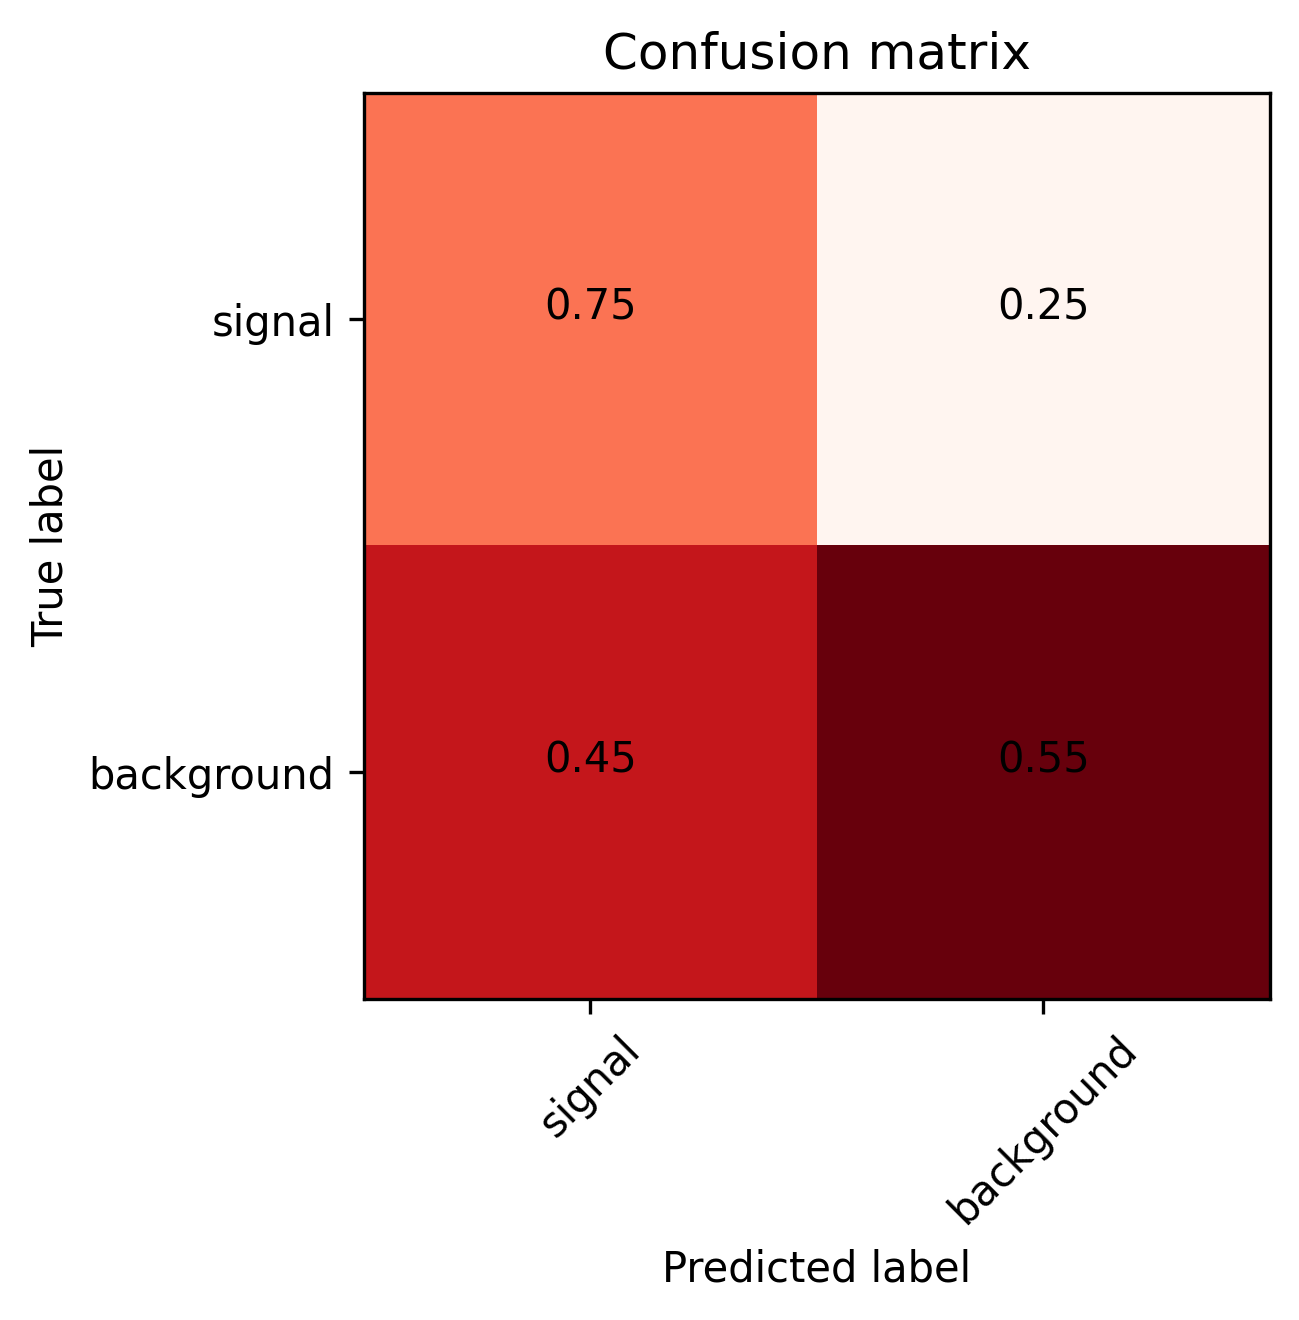

In [89]:
normalised_systematic_error_data = mm_scaler.transform(systematic_error_data)

# Get model predictions
labels_pred = model.predict(normalised_systematic_error_data)

# Convert predictions into binary values
cutoff_threshold = 0.5 
labels_pred_binary = np.where(labels_pred > cutoff_threshold, 1, 0)

# Make confsuion matrix
cm = confusion_matrix(labels_test, labels_pred_binary)
class_names = ['signal', 'background']
title = 'Confusion matrix'

# Plot confusion matrix
fig2 = plotlib.confusion_matrix(cm, class_names, title)

In [82]:
systematic_error_data = copy.deepcopy(data_test)
systematic_error = []
fscore_list = []

for i in range(0,3000,50):
    systematic_error += [i]
    systematic_jet_data = data_test.DiJet_mass.values
    systematic_error_data.loc[:,'DiJet_mass'] = systematic_jet_data + i
    
    normalised_systematic_error_data = mm_scaler.transform(systematic_error_data)
    labels_pred = model.predict(normalised_systematic_error_data)

    cutoff_threshold = 0.5 
    labels_pred_binary = np.where(labels_pred > cutoff_threshold, 1, 0)

    cm = confusion_matrix(labels_test, labels_pred_binary)
    
    fscore = f_score(cm)
    
    if i == 0:
        zero_error_score = fscore
    else:
        pass
    
    fscore_list += [fscore]    
    


Text(0.5, 1.0, 'Network response to systematic error')

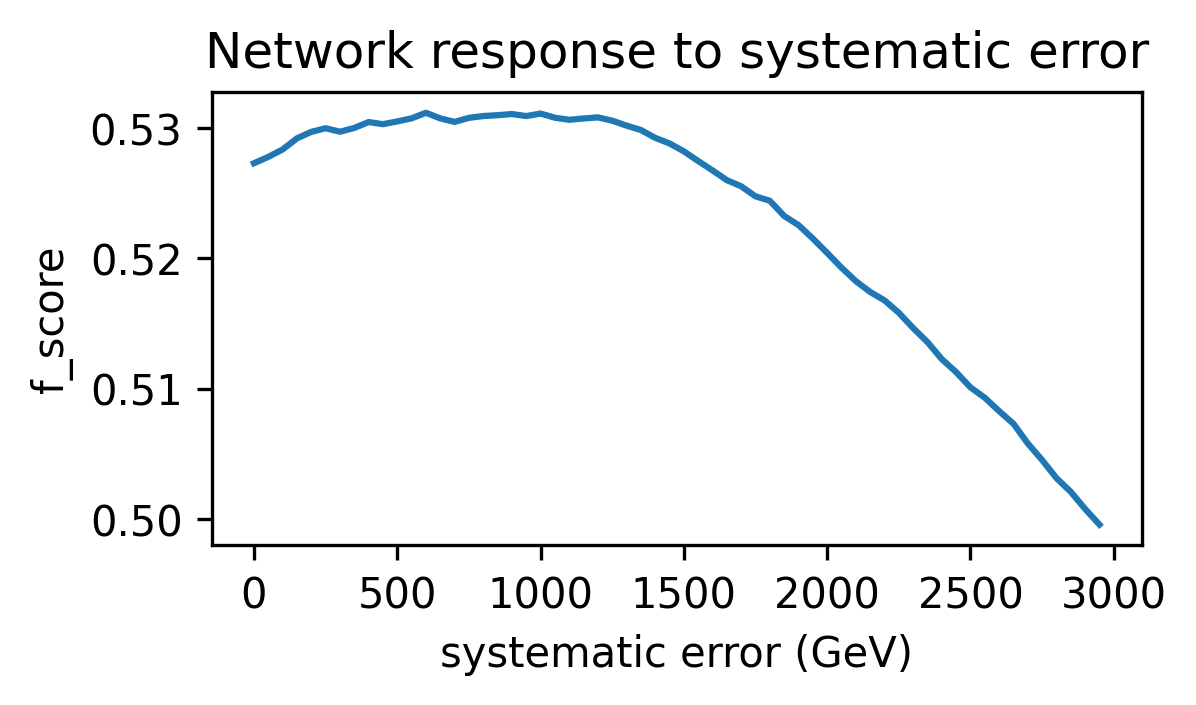

In [86]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
ax.plot(systematic_error, fscore_list)
ax.set_xlabel('systematic error (GeV)')
ax.set_ylabel('f_score')
ax.set_title('Network response to systematic error')


In [90]:
data_test.head()

,DiJet_mass,HT,MHT_pt,MetNoLep_CleanJet_mindPhi,MetNoLep_pt,MinChi,MinOmegaHat,MinOmegaTilde,min_dphi_clean_2j,nMediumBJet,ncleanedJet
1238,338.151215,1065.527832,294.507416,1.260018,302.464111,0.366397,0.366398,0.366397,2.228768,1,8
412145,86.440582,421.451538,270.752167,0.395321,284.416321,1.123538,0.926241,0.379308,2.827335,1,5
273432,310.316010,784.032288,212.443390,1.116584,220.548538,0.732482,0.732482,0.732482,1.116584,1,8
567649,875.189392,838.589233,347.836517,0.689236,366.924377,0.230057,0.553823,0.022054,0.689236,0,4
16937,315.269043,484.733673,224.047424,0.619744,230.824905,1.075462,0.803464,0.046663,0.843452,1,5


(0.0, 6000.0)

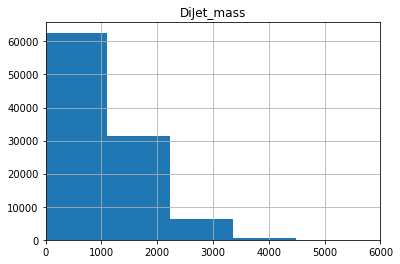

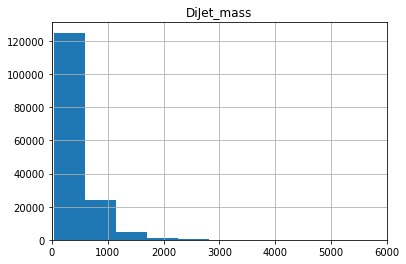

In [105]:
random_error_data = copy.deepcopy(data_test)

random_error_data.loc[:,'DiJet_mass'] = data_test.DiJet_mass.apply(lambda x:np.random.normal(x,1000))

ax1 = random_error_data.hist('DiJet_mass')
ax2 = data_test.hist('DiJet_mass')
ax1[0][0].set_xlim(0,6000)
ax2[0][0].set_xlim(0,6000)

In [109]:
measurment_error = []
f_score_list = []

for i in range(0,4000,50):
    measurment_error +=[i]
    random_error_data.loc[:,'DiJet_mass'] = data_test.DiJet_mass.apply(lambda x:np.random.normal(x,i))
    
    normalised_random_error_data = mm_scaler.transform(random_error_data)

    # Get model predictions
    labels_pred = model.predict(normalised_random_error_data)

    # Convert predictions into binary values
    cutoff_threshold = 0.5 
    labels_pred_binary = np.where(labels_pred > cutoff_threshold, 1, 0)

    # Make confsuion matrix
    cm = confusion_matrix(labels_test, labels_pred_binary)
    
    f_score_list += [f_score(cm)]


Text(0.5, 1.0, 'Network response to measurment error')

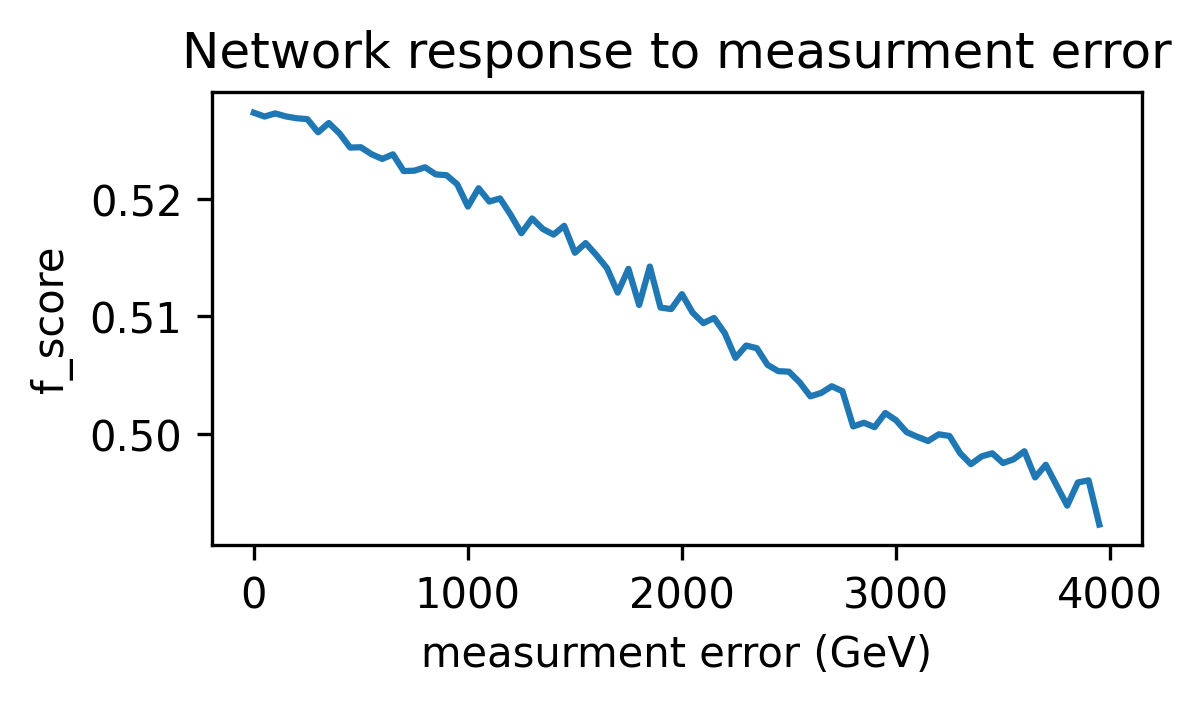

In [110]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)
ax.plot(measurment_error, f_score_list)
ax.set_xlabel('measurment error (GeV)')
ax.set_ylabel('f_score')
ax.set_title('Network response to measurment error')

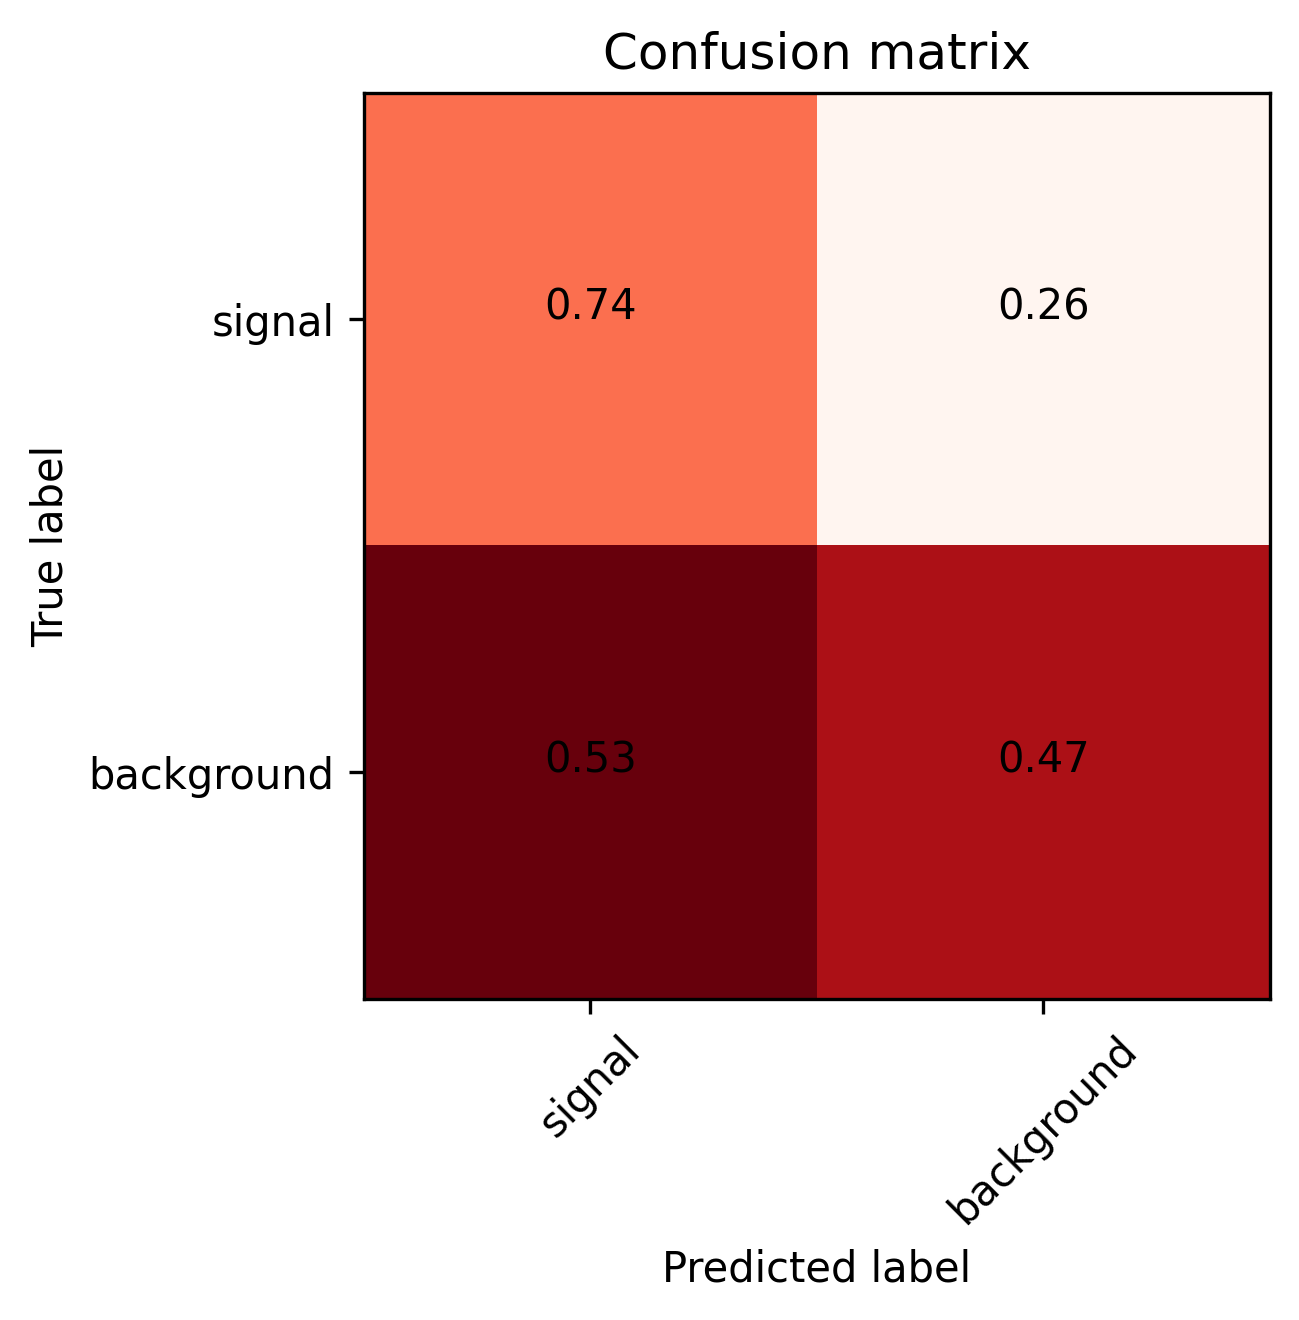

In [108]:
random_error_data

In [2]:
jet_data.columns


NameError: name 'jet_data' is not defined